In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

from scipy import stats
import seaborn as sns
from copy import deepcopy

In [2]:
import os 
os.chdir(r'E:\1数学建模比赛\联合利华-销量预测\round II\训练数据')

### 数据预处理

In [3]:
train=pd.read_csv('train_zhang.csv',encoding='gbk')
train.head()

,name,address,YTD,location,adname,type,rating,catering,accommodation,mall,...,school,bus,parking,metro,GDP,country_income,country_consume,urban_income,urban_consume,population
0,洛宁盛德美,永宁大道与翔梧路交叉口23号,35258.306670,"111.657889,34.384303",洛宁县,大型知名商超,4.5,150,9,3,...,2,1,10,0,88.1748,10740,6789,27770.0,17654.0,32.4000
1,嵩县周天,嵩县人民路白云商厦东门对面,254.013333,"112.087070,34.132395",嵩县,商场,3.5,302,75,3,...,1,50,3,0,20.1300,6455,5099,17009.0,13665.0,15.9800
2,丹尼斯洛阳南昌店,南昌路130号,80346.975000,"112.406062,34.645089",涧西区,大型知名商超,3.8,314,50,4,...,3,19,25,0,73.2280,13023,9607,25431.0,16032.0,45.2557
3,河南大张实业有限公司堰师店,偃师市偃师中医院向东50米商都路57号,48502.228330,"112.784189,34.723870",偃师市,大型知名商超,4.5,74,10,1,...,1,15,6,0,354.0161,12596,7907,22357.0,14194.0,62.1853
4,特别超市购物广场,洛阳市京津路与洛新大道交叉北90米西,0.000000,"112.307249,34.688274",新安县,商场,4.5,50,10,1,...,1,4,4,0,343.9188,9743,7254,22541.0,17820.0,47.4500


In [4]:
train.isnull().any()

name               False
address            False
YTD                False
location           False
adname             False
type               False
rating             False
catering           False
accommodation      False
mall               False
store              False
superMarket        False
personal_items     False
residence          False
business           False
hospital           False
school             False
bus                False
parking            False
metro              False
GDP                False
country_income     False
country_consume    False
urban_income       False
urban_consume      False
population         False
dtype: bool

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 26 columns):
name               315 non-null object
address            315 non-null object
YTD                315 non-null float64
location           315 non-null object
adname             315 non-null object
type               315 non-null object
rating             315 non-null float64
catering           315 non-null int64
accommodation      315 non-null int64
mall               315 non-null int64
store              315 non-null int64
superMarket        315 non-null int64
personal_items     315 non-null int64
residence          315 non-null int64
business           315 non-null int64
hospital           315 non-null int64
school             315 non-null int64
bus                315 non-null int64
parking            315 non-null int64
metro              315 non-null int64
GDP                315 non-null float64
country_income     315 non-null int64
country_consume    315 non-null int64
urban_inco

In [6]:
cat_features=['adname','type']

In [7]:
# 连续值
cont_features=[cont for cont in list(train.select_dtypes(exclude=['object']).columns)
              if cont not in ['YTD']]

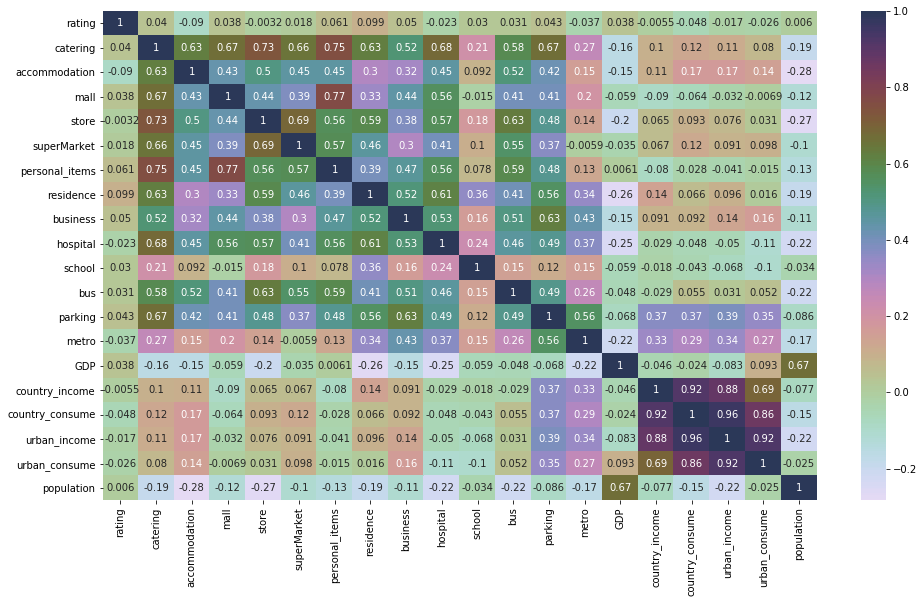

In [8]:
# 连续值特征相关性
plt.subplots(figsize=(16,9))
correlation_mat=train[cont_features].corr()
cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(correlation_mat,annot=True,cmap=cmap)
# country_consume,country_income,urban_cosume,urban_income 高度相关 

In [9]:
features=[x for x in train.columns if x not in ['name','address','YTD',
                                              'location','YTD_log',
                                              'country_income','urban_income',
                                             'urban_consume']]

In [10]:
train_x=train[features]
#train_y=train['YTD_log']
#train_y=train['YTD']
cont_features=[cont for cont in train_x.columns if cont not in ['type','adname']]
cat_features=['adname','type']
# 连续特征标准化处理
'''
for i in cont_features:
    train_x[i]=StandardScaler().fit_transform(train_x[i].values.reshape(-1,1))
'''               


# 离散特征进行数字编码
for j in cat_features:
    train_x[j]=train_x[j].astype('category').cat.codes

print("Xtrain:",train_x.shape)

Xtrain: (315, 19)


C:\Users\GDM\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
# YTD 数据倾斜
stats.mstats.skew(train['YTD']).data

array(5.94507161)

In [12]:
# 进行对数处理
def y_log(row):
    YTD=row['YTD']
    if YTD==0:
        return 0
    else:
        return np.log(YTD)
train['YTD_log']=train.apply(y_log,axis=1)

In [13]:
train_y=train['YTD_log']
stats.mstats.skew(train['YTD_log']).data

array(-0.61250174)

### XGBoost

In [14]:
model=xgb.XGBRegressor(max_depth=4,learning_rate=0.1,n_estimators=100,
                       min_child_weight=3,subsample=0.8,colsample_bytree=0.8)

In [15]:
model.fit(train_x,train_y)
yhat=model.predict(train_x)

In [16]:
from sklearn.metrics import r2_score

# Adjusted_R2：:1-((1-r2_score(y_test,y_predict))*(n-1))/(n-p-1)
def A_R2(y,yhat,n,p):
    Adjusted_R2=1-((1-r2_score(y,yhat))*(n-1))/(n-p-1)
    return Adjusted_R2

In [17]:
p=train_x.shape[1]
n=train_y.shape[0]
Adjusted_R2=A_R2(y=train['YTD_log'].values,yhat=yhat,n=n,p=p)
print('Adjusted_R2_log:',Adjusted_R2)

MSE=mean_absolute_error(train['YTD_log'].values,yhat)
print('MAE_log:',MSE)

Adjusted_R2_log: 0.8884467651779322
MAE_log: 0.8450886646627818


In [18]:
Adjusted_R2=A_R2(y=train['YTD'],yhat=np.exp(yhat),n=n,p=p)
print('Adjusted_R2:',Adjusted_R2)

MAE=mean_absolute_error(train['YTD'],np.exp(yhat))
print('MAE:',MAE)

Adjusted_R2: 0.3811182747034142
MAE: 2594.146838316716


In [19]:
test=pd.read_csv('test_zhang.csv',encoding='gbk')
test.head(5)

,name,address,location,adname,type,rating,catering,accommodation,mall,store,...,school,bus,parking,metro,GDP,country_income,country_consume,urban_income,urban_consume,population
0,103金牛量贩购物广场,王城大道101号（王城大道与邙山路交南40米东）103金牛量贩购物广场,"112.518186,34.724562",瀍河回族区,商场,3.8,50,4,0,7,...,2,4,0,0,82.7693,11128,9140,25222.11,13646.73,18.8400
1,511便利店,华夏路511便利店511便利店,"112.790458,34.718825",偃师市,便利店,3.3,353,50,5,25,...,0,25,18,0,354.0161,12596,7907,22357.00,14194.00,62.1853
2,白元乡化妆品大世界,伊川县白元乡白元中西200米,"112.413869,34.355109",伊川县,个人用品,3.3,13,1,0,1,...,0,6,0,0,290.0000,8730,6750,19024.00,14805.00,45.6600
3,百惠批发超市,洛阳市西区一街与龙门大道交叉东50米南,"112.472519,34.627485",洛龙区,便利店,3.3,100,9,0,24,...,0,12,6,1,172.4000,14086,14312,33971.00,23477.00,38.6900
4,百蔬园生活超市,洛阳市展览路与通济街交叉东50米南,"112.444202,34.613600",洛龙区,超级市场,3.7,75,15,0,19,...,2,10,19,2,172.4000,14086,14312,33971.00,23477.00,38.6900


In [20]:
test_features=[x for x in test.columns if x not in ['name','address','location',
                                              'country_income','urban_income',
                                             'urban_consume']]

In [21]:
test_x=test[test_features]

cat_features=['adname','type']
for j in cat_features:
    test_x[j]=test_x[j].astype('category').cat.codes
print("Xtest:",test_x.shape)

Xtest: (140, 19)


C:\Users\GDM\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [22]:
yhat=model.predict(test_x)

In [23]:
yhat=np.exp(yhat)

In [26]:
#numpy.savetxt('new.csv', my_matrix, delimiter = ',')  
np.savetxt('test_pre.csv',yhat)

In [27]:
model.feature_importances_

array([0.06838429, 0.09808408, 0.12522212, 0.03722252, 0.02629535,
       0.03935047, 0.0448435 , 0.0384834 , 0.05970908, 0.06090398,
       0.03809615, 0.03098162, 0.04569777, 0.03216499, 0.02682856,
       0.04988783, 0.03220002, 0.12143734, 0.02420693], dtype=float32)

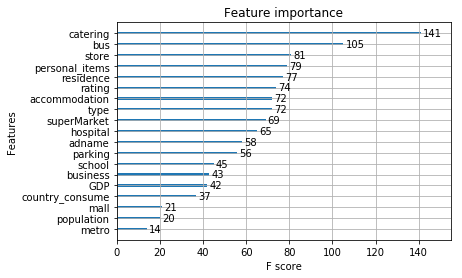

In [28]:
from xgboost import plot_importance
plot_importance(model)

### LGBM

In [34]:
train_y.shape,train_x.shape

((315,), (315, 19))

In [55]:
from lightgbm.sklearn import LGBMRegressor
lgb_model=LGBMRegressor(boosting_type='gbdt')

In [57]:
lgb_model.fit(train_x,train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [58]:
lgb_yhat=lgb_model.predict(train_x)

In [59]:
p=train_x.shape[1]
n=train_y.shape[0]
Adjusted_R2=A_R2(y=train['YTD_log'].values,yhat=lgb_yhat,n=n,p=p)
print('Adjusted_R2_log:',Adjusted_R2)

MSE=mean_absolute_error(train['YTD_log'].values,lgb_yhat)
print('MAE_log:',MSE)

Adjusted_R2_log: 0.8435807670586215
MAE_log: 0.9918456082512148


In [60]:
Adjusted_R2=A_R2(y=train['YTD'],yhat=np.exp(lgb_yhat),n=n,p=p)
print('Adjusted_R2:',Adjusted_R2)

MAE=mean_absolute_error(train['YTD'],np.exp(lgb_yhat))
print('MAE:',MAE)

Adjusted_R2: 0.2508368123078092
MAE: 2876.31099229196


In [72]:
lgb_test_hat=lgb_model.predict(test_x)
lgb_test_hat=np.exp(lgb_test_hat)

In [74]:
np.savetxt('lgb_yhat.csv',lgb_test_hat)

In [64]:
lgb_model.feature_importances_

array([ 17,  74,  60, 123,  86,  18,  80,  83,  80, 107,  29,  66,  37,
       102,  74,   5,  33,  32,  17])

<Figure size 864x432 with 0 Axes>

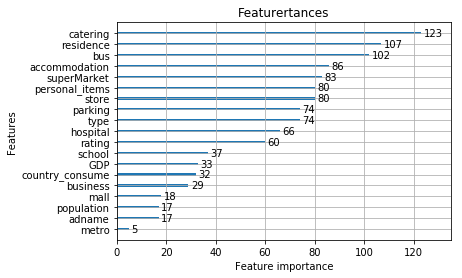

In [71]:
import lightgbm as lgb
plt.figure(figsize=(12,6))
lgb.plot_importance(lgb_model)
plt.title("Featurertances")
plt.show()